In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/.ipynb_checkpoints'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/pascal_val2012.json')]

In [4]:
for i in PATH.iterdir(): print(i)

data/pascal/pascal_val2007.json
data/pascal/VOCdevkit
data/pascal/pascal_train2012.json
data/pascal/pascal_test2007.json
data/pascal/models
data/pascal/PASCAL_VOC.zip
data/pascal/.ipynb_checkpoints
data/pascal/pascal_train2007.json
data/pascal/tmp
data/pascal/pascal_val2012.json


In [5]:
o = list(PATH.iterdir())[0]
str(o)

'data/pascal/pascal_val2007.json'

In [6]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [7]:
trn_j['type']

'instances'

In [8]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
print(len(trn_j[IMAGES]), type(trn_j[IMAGES][0]))
trn_j[IMAGES][:5]

2501 <class 'dict'>


[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [9]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [10]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [11]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id',\
                                    'category_id','bbox'
cats = {o[ID]: o['name'] for o in trn_j[CATEGORIES]}
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [12]:
len(cats), len(trn_ids), len(trn_fns)

(20, 2501, 2501)

In [13]:
(PATH/'VOCdevkit'/'VOC2007').iterdir()

<generator object Path.iterdir at 0x1c1f21c888>

In [14]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')]

In [15]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [16]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/003301.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006279.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008254.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007167.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000608.jpg')]

In [17]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

In [18]:
trn_anno = collections.defaultdict(list)
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
len(trn_anno)

2501

In [19]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [20]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [21]:
cats[7]

'car'

In [22]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [23]:
cats[15], cats[13]

('person', 'horse')

In [24]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [25]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [26]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False,
                                        edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top',
                   color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

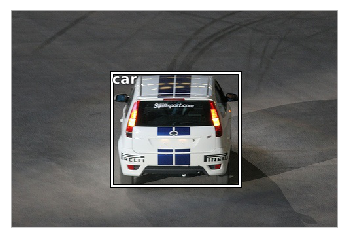

In [27]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [28]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]    
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

In [29]:
trn_ids[:5]

[12, 17, 23, 26, 32]

(364, 480, 3)


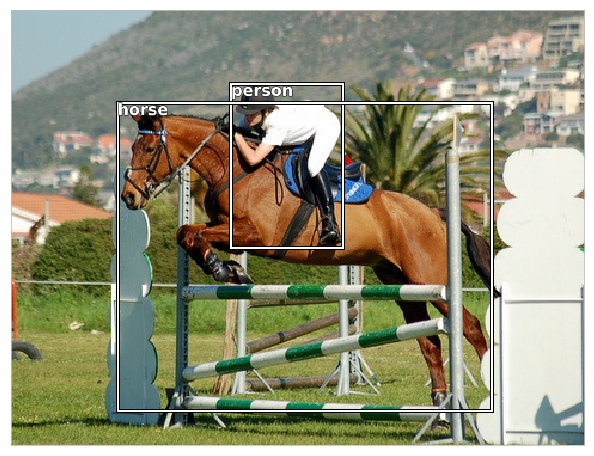

In [30]:
draw_idx(17)

(281, 500, 3)


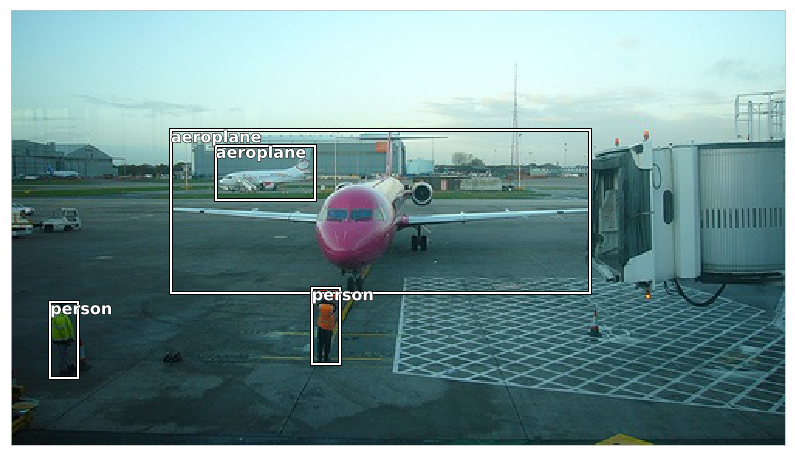

In [31]:
draw_idx(32)

In [32]:
def get_lrg(b):
    if not b: raise Exeption()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [33]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

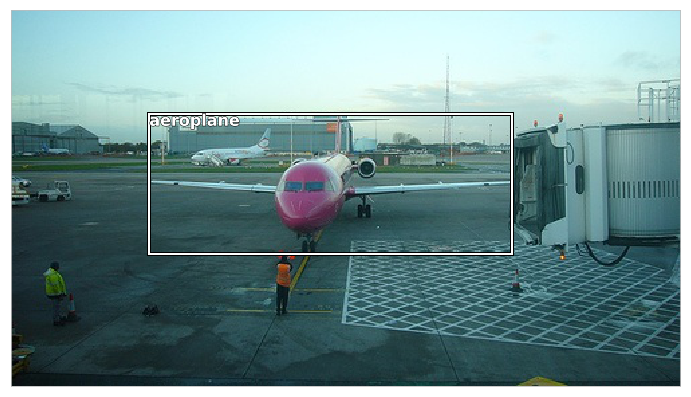

In [34]:
b,c = trn_lrg_anno[32]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[32]),figsize=(12,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [35]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]},
                   columns=['fn','cat'])
df.to_csv(CSV, index=False)
pd.read_csv(CSV).head()

,fn,cat
0,000012.jpg,car
1,000017.jpg,horse
2,000023.jpg,person
3,000026.jpg,car
4,000032.jpg,aeroplane


In [36]:
f_model = resnet34
sz=224
bs=64

In [37]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on,
                      crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


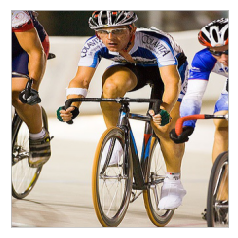

In [40]:
x,y=next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [41]:
print(y.shape); print(y[:2]); print(x.shape)

torch.Size([64])

 14
 17
[torch.LongTensor of size 2]

torch.Size([64, 3, 224, 224])


In [64]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [ ]:
lrf=learn.lr_find(1e-5,100)

In [ ]:
learn.sched.plot()

In [ ]:
learn.sched.plot(n_skip=5, n_skip_end=1)
plt.axvline(x=2e-2, color='red')

In [ ]:
lr = 2e-2

In [ ]:
learn.fit(lr, 1, cycle_len=1)

In [ ]:
lrs = np.array([lr/1000,lr/100,lr])

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrf=learn.lr_find(lrs/1000)

In [ ]:
learn.sched.plot(1)
plt.axvline(x=lrs[-1]/70, color='red')

In [ ]:
learn.fit(lrs/5, 1, cycle_len=1)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs/5, 1, cycle_len=2)

In [ ]:
learn.save('class_one')

In [ ]:
learn.load('class_one')